### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
from nltk.corpus import stopwords
import re
import joblib
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, confusion_matrix


### Data Overview

In [2]:
# Concate the train data
data_path = os.path.join(os.getcwd(), "..", "DataSets")
train_Postive_data_path = os.path.join(data_path, "train_Arabic_tweets_positive_20190413.tsv")
train_negative_data_path = os.path.join(data_path, "train_Arabic_tweets_negative_20190413.tsv")
train_Postive_data = pd.read_csv(train_Postive_data_path, sep="\t", encoding="utf-8", header=None)
train_negative_data = pd.read_csv(train_negative_data_path,  sep="\t", encoding="utf-8", header=None)

train_data = pd.concat([train_Postive_data, train_negative_data], ignore_index=True)
train_data.columns = ["sentiment", "tweet"]
train_data

,sentiment,tweet
0,pos,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...
1,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...
2,pos,من الخير نفسه 💛
3,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...
4,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...
...,...,...
45270,neg,كيف ترى أورانوس لو كان يقع مكان القمر ؟ 💙💙 كوك...
45271,neg,احسدك على الايم 💔
45272,neg,لأول مرة ما بنكون سوا 💔
45273,neg,بقله ليش يا واطي 🤔


In [3]:
# Concate the test data
data_path = os.path.join(os.getcwd(), "..", "DataSets")
test_Postive_data_path = os.path.join(data_path, "test_Arabic_tweets_positive_20190413.tsv")
test_negative_data_path = os.path.join(data_path, "test_Arabic_tweets_negative_20190413.tsv")
test_Postive_data = pd.read_csv(test_Postive_data_path, sep="\t", encoding="utf-8", header=None)
test_negative_data = pd.read_csv(test_negative_data_path,  sep="\t", encoding="utf-8", header=None)

test_data = pd.concat([test_Postive_data, test_negative_data], ignore_index=True)
test_data.columns = ["sentiment", "tweet"]
test_data

,sentiment,tweet
0,pos,#الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران...
1,pos,صباحك خيرات ومسرات 🌸
2,pos,#تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫...
3,pos,😂😂 يا جدعان الرجاله اللي فوق ال دول خطر ع تويت...
4,pos,رساله صباحيه : 💛 اللهم اسألك التوفيق في جميع ا...
...,...,...
11515,neg,النوم وانت مكسور ده احساس غبي اللي هو مش قادر ...
11516,neg,استشهاد_الامام_كاظم_الغيظ السلام على المعذب في...
11517,neg,انا كنت اكل الصحن بكبره 😐
11518,neg,قولوا لي ايش تشوفوا .. مع ملاحظة التلطف لأنه ا...


In [4]:
# Some data information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45275 entries, 0 to 45274
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  45275 non-null  object
 1   tweet      45275 non-null  object
dtypes: object(2)
memory usage: 707.6+ KB


### EDA

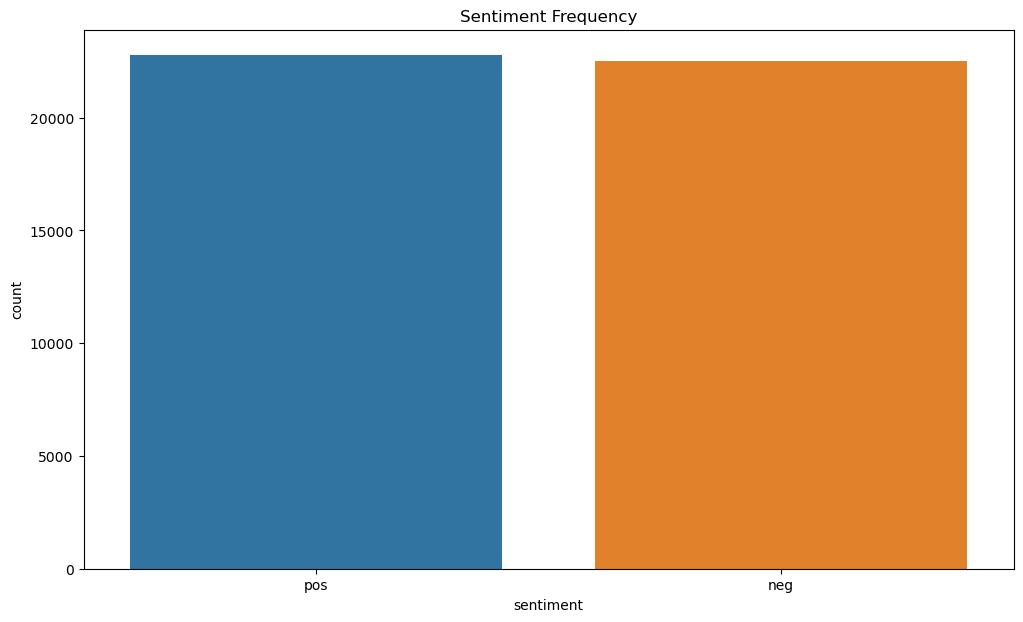

In [5]:
plt.figure(figsize=(12, 7))
sns.countplot(data=train_data, x="sentiment")
plt.title("Sentiment Frequency")
plt.show()

### Data preprocessing

In [6]:
class Preprocessor:
    def __init__(self, Stemmer):
        self.Stemmer = Stemmer

    def clean(self, text):
        text = str(text)

        # Remove emojis
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F700-\U0001F77F"  # alchemical symbols
                                   u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                   u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                   u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                   u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                   u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                   u"\U00002702-\U000027B0"  # Dingbats
                                   u"\U000024C2-\U0001F251"  # Enclosed characters
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r"", text)

        # Remove emails, URLs
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'http\S+|www\S+', '', text)

        # Normalize spaces
        text = re.sub(r'\s+', ' ', text).strip()

        # Split the text into words
        words = text.split()

        # Arabic stopwords list
        arabic_stopwords = [
            "في", "من", "على", "إلى", "و", "مع", "حتى", "ثم", "إن", "أن", "كان", "قد",
            "كل", "نحن", "أنت", "هو", "هي", "هم", "هن", "أو", "بل", "لكن", "هذا", "هذه",
            "ذلك", "تلك", "هناك", "هنا", "الذي", "التي", "اللذان", "اللتان", "الذين", "اللائي",
            "إذا", "متى", "أين", "كيف", "لماذا", "ب", "ك", "ل",
        ]

        # Remove stopwords
        words = [word for word in words if word not in arabic_stopwords]

        # Lemmatize the words
        words = [self.Stemmer.stem(word) for word in words]

        # Join words into a cleaned text
        cleaned_text = " ".join(words)
        return cleaned_text


snow_stemmer = SnowballStemmer(language="arabic")
processor = Preprocessor(Stemmer=snow_stemmer)
train_data["CleanedTweet"] = train_data["tweet"].apply(processor.clean)

In [7]:
train_data

,sentiment,tweet,CleanedTweet
0,pos,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...,يتحول ما نود نقول دعاء لله لا تبحث فين عن قو ا...
1,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,وف نها لن يبقىٰ معك احدال راىٰ جمال روح اماالم...
2,pos,من الخير نفسه 💛,خير نفس
3,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...,#زلزل_الملعب_نصرنا_بيلعب كن عال همه ولا ترضى غ...
4,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...,شيء وحيد صلو فيه عالم : مسيار ..! . ترى كانو ي...
...,...,...,...
45270,neg,كيف ترى أورانوس لو كان يقع مكان القمر ؟ 💙💙 كوك...,ترى اورانوس لو يقع مكا قمر كوكب بعد عن شمس يب...
45271,neg,احسدك على الايم 💔,احسد ايم
45272,neg,لأول مرة ما بنكون سوا 💔,لاول مر ما نكو سوا
45273,neg,بقله ليش يا واطي 🤔,بقل ليش يا واط


In [8]:
# convert the target to numeric classes
target_to_num = {
     "pos": 0,
     "neg": 1
}

train_data["sentiment"].replace(target_to_num, inplace=True)

In [10]:
train_data

,sentiment,tweet,CleanedTweet
0,0,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...,يتحول ما نود نقول دعاء لله لا تبحث فين عن قو ا...
1,0,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,وف نها لن يبقىٰ معك احدال راىٰ جمال روح اماالم...
2,0,من الخير نفسه 💛,خير نفس
3,0,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...,#زلزل_الملعب_نصرنا_بيلعب كن عال همه ولا ترضى غ...
4,0,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...,شيء وحيد صلو فيه عالم : مسيار ..! . ترى كانو ي...
...,...,...,...
45270,1,كيف ترى أورانوس لو كان يقع مكان القمر ؟ 💙💙 كوك...,ترى اورانوس لو يقع مكا قمر كوكب بعد عن شمس يب...
45271,1,احسدك على الايم 💔,احسد ايم
45272,1,لأول مرة ما بنكون سوا 💔,لاول مر ما نكو سوا
45273,1,بقله ليش يا واطي 🤔,بقل ليش يا واط


In [11]:
# Split to features and target
X = train_data["CleanedTweet"]
y = train_data["sentiment"]

# split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, shuffle=True, stratify=y)

In [12]:
# Make data victorization
tf_idf = TfidfVectorizer(max_features=1500, ngram_range=(1, 3))
victorized_train_data = tf_idf.fit_transform(X_train)
victorized_test_data = tf_idf.transform(X_test)

In [13]:
victorized_train_data = pd.DataFrame(victorized_train_data.toarray(), columns=tf_idf.get_feature_names_out())
victorized_test_data = pd.DataFrame(victorized_test_data.toarray(), columns=tf_idf.get_feature_names_out())


In [14]:
victorized_train_data

,00,12,12 اتحاد,__,boy,boy with,boy with luv,luv,neg,pos,...,يهم,يوم,يوم تغريداتك,يوم تغريداتك اكثر,يوم قال,يوم قال ربيع,يوم_الجمع,ٲليس,ٲليس عيب,ٲليس عيب ان
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# make a models folder 
model_path = os.path.join(os.getcwd(), "..", "models")
os.makedirs(model_path, exist_ok=True)

In [16]:
# dumb the preprocessor and tf_idf model
joblib.dump(processor, os.path.join(model_path, "processor.pkl"))
joblib.dump(tf_idf, os.path.join(model_path, "tf-idf.pkl"))

['f:\\Agoor Projects\\Text Classification\\notebook\\..\\models\\tf-idf.pkl']

### Built models

#### `RandomForest`

In [19]:
forest_clf = RandomForestClassifier(n_estimators=200, max_depth=10, 
                                    min_samples_split=4, min_samples_leaf=3, random_state=42)

forest_clf.fit(victorized_train_data, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=4,
                       n_estimators=200, random_state=42)

In [20]:
forest_prediction = forest_clf.predict(victorized_test_data)

print("F1 Score:")
print(f1_score(y_test, forest_prediction))
print("--"*10)
print("Classification Report:")
print(classification_report(y_test, forest_prediction))

F1 Score:
0.7101249925243704
--------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.41      0.54      6829
           1       0.60      0.88      0.71      6754

    accuracy                           0.64     13583
   macro avg       0.68      0.64      0.62     13583
weighted avg       0.69      0.64      0.62     13583



#### `XGBoost`

In [23]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators= 200, 
                            learning_rate= 0.1, max_depth=10, random_state=42)

xgb_clf.fit(victorized_train_data, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [24]:
xgb_prediction = xgb_clf.predict(victorized_test_data)

print("F1 Score:")
print(f1_score(y_test, xgb_prediction))
print("--"*10)
print("Classification Report:")
print(classification_report(y_test, xgb_prediction))

F1 Score:
0.7583272388803936
--------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70      6829
           1       0.69      0.84      0.76      6754

    accuracy                           0.73     13583
   macro avg       0.74      0.73      0.73     13583
weighted avg       0.75      0.73      0.73     13583



In [25]:
# dumb the models
joblib.dump(processor, os.path.join(model_path, "randomforest.pkl"))
joblib.dump(tf_idf, os.path.join(model_path, "xgboost.pkl"))

['f:\\Agoor Projects\\Text Classification\\notebook\\..\\models\\xgboost.pkl']